In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

In [2]:
df = pd.read_csv('baseDeDados.csv', sep=';')

/media/user/DADOS1/anaconda/envs/iainverno/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def extend_list(lst):
    """
    Função utilitária para o pré-processamento da tabela de dependências.
    Uniformiza o tamanho de sublistas.
    """
    try:
        lst[2]
    except:
        lst.append('')
    return lst

def list_to_int(lst):
    """
    Função utilitária para o pré-processamento da tabela de dependências.
    Gera uma lista de dependências.
    """
    new_lst = []
    for item in lst:
        try:
            new_lst.append(int(item))
        except:
            continue
    return new_lst

def levenshtein(s1, s2):
    """
    Função utilitária para o pré-processamento de tabelas.
    Mede a distância Levenshtein ( distância de edição ) entre duas strings.
    """
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1       
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def tabela_notas(df):
    """
    Retorna a média geral dos alunos em cada matéria.
    """
    return df[['nome_componente', 'nota_discente_componente']]\
    .groupby('nome_componente')\
    .mean()\
    .to_dict()\
    ['nota_discente_componente']

def tabela_dependencias_grade_nova(df):
    """
    Esta função transforma o texto abaixo, copiado de 
    http://inf.ufg.br/sites/default/files/uploads/Resolucao_CEPEC_2017_1561.pdf ,
    em uma tabela de dependências para a grade nova.
    """
    novos_requisitos = """
    01 Álgebra Linear IME 64 0 64 NC OBR
    02 Algoritmos e Estruturas de Dados 1 INF 26 32 32 64 NC OBR
    03 Algoritmos e Estruturas de Dados 2 INF 2 64 0 64 NC OBR
    04 Análise e Projeto de Algoritmos INF 21, 03 64 0 64 NC OBR
    05 Arquitetura de Computadores INF 21 48 16 64 NC OBR
    06 Banco de Dados INF 29 48 16 64 NC OBR
    07 Cálculo 1A IME 96 0 96 NC OBR
    08 Cálculo 2A IME 7 96 0 96 NE OBR
    09 Cálculo Numérico IME 18 64 0 64 NE OBR
    10 Circuitos Digitais EMC 21 64 0 64 NE OBR
    11 Compiladores INF 03, 28 48 16 64 NE OBR
    12 Computação e Sociedade INF 32 0 32 NC OBR
    13 Computação Gráfica INF 22 32 32 64 NE OBR
    14 Computação Paralela INF 39 48 16 64 NE OBR
    15 Eletrônica para Computação EMC 20 96 0 96 NE OBR
    16 Engenharia de Requisitos INF 16 48 64 NE OBR
    17 Engenharia de Software INF 64 0 64 NC OBR
    18 Equações Diferenciais Ordinárias IME 01, 08 64 0 64 NE OBR
    19 Física I IF 7 64 0 64 NE OBR
    20 Física III IF 19 64 0 64 NE OBR
    21 Fundamentos de Matemática para Computação INF 64 0 64 NC OBR
    22 Geometria Analítica IME 64 0 64 NE OBR
    23 Inteligência Artificial INF 02, 29, 33 64 0 64 NE OBR
    24 Interação Humano-Computador INF 02, 33 32 32 64 NC OBR
    25 Introdução à Computabilidade e à Complexidade Computacional INF 04, 28 64 0 64 NE OBR
    26 Introdução à Programação INF 48 80 128 NC OBR
    27 Linguagens e Paradigmas de Programação INF 26 32 32 64 NC OBR
    28 Linguagens Formais e Autômatos INF 21 64 0 64 NE OBR
    29 Lógica Matemática INF 21 64 0 64 NC OBR
    30 Matemática Discreta INF 21 64 0 64 NE OBR
    31 Metodologia de Pesquisa em Computação INF 32 0 32 NE OBR
    32 Pesquisa Operacional INF 1 64 0 64 NE OBR
    33 Probabilidade e Estatística A IME 7 64 0 64 NC OBR
    34 Programação Orientada a Objetos INF 26 32 32 64 NC OBR
    35 Projeto de Software INF 17, 34 64 0 64 NC OBR
    36 Projeto Final de Curso 1 INF 0 64 64 NE OBR
    37 Projeto Final de Curso 2 INF 36 0 64 64 NE OBR
    38 Redes de Computadores 1 INF 48 16 64 NE OBR
    39 Sistemas Distribuídos INF 38 48 16 64 NE OBR
    40 Sistemas Gerenciadores de Banco de Dados INF 6 64 0 64 NE OBR
    41 Sistemas Operacionais INF 02, 05 64 0 64 NE OBR
    42 Software Básico INF 2 0 64 64 NE OBR
    43 Teoria dos Grafos INF 30 64 0 64 NE OBR
    44 Aprendizagem de Máquina e Mineração de Dados INF 23 32 32 64 NE OPT
    45 Armazém de Dados INF 40 48 16 64 NE OPT
    46 Avaliação de Desempenho de Sistemas Computacionais INF 33 64 0 64 NE OPT
    47 Banco de Dados Distribuídos INF 40 64 0 64 NE OPT
    48 Computação Evolucionária INF 32 32 64 NE OPT
    49 Computação Móvel e Ubíqua INF 34, 35 16 48 64 NE OPT
    50 Computação Verde INF 38 32 32 64 NE OPT
    51 Desenvolvimento de Sistemas para Web INF 34 32 32 64 NE OPT
    52 Desenvolvimento de Software Dirigido por Modelos INF 02, 34 32 32 64 NE OPT
    53 Empreendedorismo Digital INF 32 32 64 NE OPT
    54 Engenharia de Sistemas INF 64 0 64 NE OPT
    55 Engenharia de Software Baseada em Busca INF 17 32 32 64 NE OPT
    56 Fundamentos da Programação Lógica e Funcional INF 27, 29 64 0 64 NE OPT
    57 Integração de Dados INF 40 64 0 64 NE OPT
    58 Introdução à Língua Brasileira de Sinais FL 64 0 64 NE OPT
    59 Introdução à Teoria das Provas INF 29 64 0 64 NE OPT
    60 Introdução à Teoria dos Tipos INF 29 64 0 64 NE OPT
    61 Jogos Digitais INF 34 16 48 64 NE OPT
    62 Meta-heurísticas INF 2 64 0 64 NE OPT
    63 Metodologia e Experimentação em Engenharia de Software INF 64 0 64 NE OPT
    64 Microcontroladores INF 10, 26 32 32 64 NE OPT
    65 Processamento Digital de Imagens INF 01, 26 64 0 64 NE OPT
    66 Recuperação de Informação INF 02, 33 64 0 64 NE OPT
    67 Redes de Computadores 2 INF 38 32 32 64 NE OPT
    68 Redes Neuronais Artificiais INF 23 32 32 64 NE OPT
    69 Segurança e Auditoria de Sistemas INF 38 32 32 64 NE OPT
    70 Sistemas Multiagentes INF 34 32 32 64 NE OPT
    71 Tópicos Avançados em Redes Sem Fio INF 16 48 64 NE OPT
    72 Tópicos em Computação INF 64 0 64 NE OPT
    73 Tópicos em Teste de Software INF 48 16 64 NE OPT
    74 Verificação Formal de Programas INF 29 32 32 64 NE OPT
    75 Visão Robótica INF 01, 65 64 0 64 NE OPT
    76 Visualização de Informações INF 3 32 32 64 NE OPT
    77 Web Semântica INF 34 32 32 64 NE OPT
    """.split('\n')[1:-1]

    novos_requisitos = [ re.sub('[0-9]* [0-9]* [0-9]* [A-Z]* [A-Z]*$', '', line) for line in novos_requisitos ]

    novos_requisitos = [ re.split('(^[0-9]* )', line)[1:] for line in novos_requisitos ]

    novos_requisitos = [ [x[0]] + re.split(' [A-Z][A-Z][A-Z]? ', x[1]) for x in novos_requisitos ]

    novos_requisitos = [ extend_list(x) for x in novos_requisitos ]

    novos_requisitos = [ x[1:] for x in novos_requisitos ]
    
    for idx, item in enumerate(novos_requisitos):
        tmp = []
        p1 = item[0]
        p2 = item[1]
        p1 = p1.lstrip()
        p1 = p1.split(' ', 1)
        tmp.extend(p1)
        tmp.append(p2)
        if len(tmp) == 2:
            tmp.append([])
        novos_requisitos[idx] = tmp
              
    novos_requisitos = [
        {
            "key": int(x[0]),
            "name": x[1],
            "deps": list_to_int(x[2].split(','))
        } for x in novos_requisitos
    ]
    
    materias_tabela = df[df['codigo_matriz_curricular']=='CICOMP-BI-3']['nome_componente'].drop_duplicates().values

    grafo_requisitos = []
    for x in materias_tabela:
        distances = []
        names = []
        for y in novos_requisitos:
            distances.append( levenshtein(x.lower(),y['name'].lower()) )
            names.append(y['name'])
        match = names[distances.index(min(distances))]
        for y in novos_requisitos:
            if y['name'] == match:
                y['name'] = x
                grafo_requisitos.append(y)

    for item in grafo_requisitos:
        deps = item['deps']
        for idx,dep in enumerate(deps):
            for item2 in grafo_requisitos:
                if item2['key'] == dep:
                    item['deps'][idx] = item2['name']

    dependencias_grade_nova = []
    for item in grafo_requisitos:
        for dep in item['deps']:
            row = {
                "materia": item['name'],
                "dependencia": dep
            }
            dependencias_grade_nova.append(row)
    dependencias_grade_nova = pd.DataFrame(dependencias_grade_nova)
    return dependencias_grade_nova

def tabela_dependencias_grade_antiga(df):
    """
    Esta função transforma o dicionário abaixo, elaborado a partir de 
    http://www.inf.ufg.br/sites/default/files/ProjetoPedagogico2008.pdf ,
    em uma tabela de dependências para a grade nova.
    """
    requisitos = [
        {
        "materia": "Programação de Computadores 2",
        "dependencia": "Programação de Computadores 1"
    },
        {
        "materia": "Estrutura de Dados I",
        "dependencia": "Programação de Computadores 1"
    },
        {
        "materia": "Programação Orientada a Objetos",
        "dependencia": "Programação de Computadores 1"
    },
        {
        "materia": "Linguagens de Programação",
        "dependencia": "Programação de Computadores 1"
    },
        {
        "materia": "Estruturas de Dados II",
        "dependencia": "Estruturas de Dados I"
    },
        {
        "materia": "Análise e Projeto de Algoritmos",
        "dependencia": "Estruturas de Dados I"
    },
        {
        "materia": "Teoria da Computação",
        "dependencia": "Linguagens Formais e Autômatos"
    },
        {
        "materia": "Compiladores",
        "dependencia": "Linguagens Formais e Autômatos"
    },    
        {
        "materia": "Compiladores",
        "dependencia": "Estruturas de Dados II"
    },
        {
        "materia": "Redes de Computadores 2",
        "dependencia": "Redes de Computadores 1"
    },
        {
        "materia": "Sistemas Distribuídos",
        "dependencia": "Redes de Computadores 1"
    },
        {
        "materia": "Inteligência Artificial",
        "dependencia": "Lógica Matemática"
    },
        {
        "materia": "Banco de Dados",
        "dependencia": "Lógica Matemática"
    },
        {
        "materia": "Sistemas Gerenciadores de BD",
        "dependencia": "Banco de Dados"
    },
        {
        "materia": "Sistemas Operacionais 2",
        "dependencia": "Sistemas Operacionais 1"
    },
        {
        "materia": "Cálculo 2",
        "dependencia": "Cálculo 1"
    },
        {
        "materia": "Projeto Final de Curso 2",
        "dependencia": "Projeto Final de Curso 1"
    }
    ]


    materias_tabela = df[df['codigo_matriz_curricular']=='CICOMP-BI-2']['nome_componente'].drop_duplicates().values

    for idx, req in enumerate(requisitos):
        for key, value in req.items():
            tmp = []
            for materia in materias_tabela:
                lev = levenshtein(value.lower(), materia.lower())
                if lev < 10:
                    tmp.append( [ lev, materia ] )
            tmp = sorted(tmp, key=lambda x: x[0])
            try:
                new_value = tmp[0][1]
                requisitos[idx][key] = new_value
            except:
                pass

    dependencias_grade_antiga = pd.DataFrame(requisitos)
    return dependencias_grade_antiga

def tabela_equivalencias(df):
    """
    Sugere uma tabela de equivalências entre matérias.
    """
    materias_novas = df[df['codigo_matriz_curricular']=='CICOMP-BI-3']['nome_componente'].drop_duplicates().values
    materias_antigas = df[df['codigo_matriz_curricular']=='CICOMP-BI-2']['nome_componente'].drop_duplicates().values

    equivalencias = []
    for mn in materias_novas:
        tmp = []
        for ma in materias_antigas:
            lev = levenshtein(mn, ma)
            if lev < 10:
                tmp.append( [levenshtein(mn, ma), ma] )
                tmp = sorted(tmp, key=lambda x: x[0])
        if not tmp:
            continue
        match = tmp[0][1]
        row = {
                "nova": mn,
                "antiga": match
            }
        equivalencias.append(row)
    equivalencias = \
    [{'nova': 'CÁLCULO 1A', 'antiga': 'CÁLCULO 1'},
     {'nova': 'CÁLCULO 2A', 'antiga': 'CÁLCULO 2'},
    #  {'nova': 'FÍSICA III', 'antiga': 'TÓPICOS 1'},
     {'nova': 'ÁLGEBRA LINEAR', 'antiga': 'ÁLGEBRA LINEAR'},
     {'nova': 'PROBABILIDADE E ESTATÍSTICA A',
      'antiga': 'PROBABILIDADE E ESTATÍSTICA'},
    #  {'nova': 'MATEMÁTICA DISCRETA', 'antiga': 'MATEMÁTICA DISCRETA'},
     {'nova': 'PROGRAMAÇÃO ORIENTADA A OBJETOS',
      'antiga': 'PROGRAMAÇÃO ORIENTADA A OBJETOS'},
     {'nova': 'ARQUITETURA DE COMPUTADORES',
      'antiga': 'ARQUITETURA DE COMPUTADORES'},
     {'nova': 'ANÁLISE E PROJETO DE ALGORITMOS',
      'antiga': 'ANÁLISE E PROJETO DE ALGORITMOS'},
     {'nova': 'BANCO DE DADOS', 'antiga': 'BANCO DE DADOS'},
     {'nova': 'COMPUTAÇÃO E SOCIEDADE', 'antiga': 'COMPUTADOR E SOCIEDADE'},
    #  {'nova': 'FÍSICA I', 'antiga': 'TÓPICOS 1'},
     {'nova': 'LÓGICA MATEMÁTICA', 'antiga': 'LÓGICA MATEMÁTICA'},
     {'nova': 'ENGENHARIA DE SOFTWARE', 'antiga': 'ENGENHARIA DE SOFTWARE'},
     {'nova': 'INTRODUÇÃO À PROGRAMAÇÃO', 'antiga': 'INTRODUÇÃO À COMPUTAÇÃO'}]

    manual = [
        {'nova': 'ALGORITMOS E ESTRUTURAS DE DADOS 1', 'antiga': 'ESTRUTURAS DE DADOS I'},
        {'nova': 'ALGORITMOS E ESTRUTURAS DE DADOS 2', 'antiga': 'ESTRUTURAS DE DADOS II'}]
    equivalencias += manual
    equivalencias = pd.DataFrame(equivalencias)
    return equivalencias

In [4]:
class Aluno(object):
    """
    Objeto que representa um aluno hipotético, gerado automaticamente.
    """
    def __init__(self, df, grade_nova=False):
        self.df = df
        self.grade_nova = grade_nova
        self.equivalencias = tabela_equivalencias(df)
        self.deps_antiga = tabela_dependencias_grade_antiga(df)
        self.deps_nova = tabela_dependencias_grade_nova(df)
        self.notas = tabela_notas(df)
        
    def fluxo(self, periodo):
        """
        Retorna as matérias previstas para um período pelo fluxo.
        """
        if self.grade_nova:
            idx = '3'
        else:
            idx = '2'
        tmp = self.df[self.df['codigo_matriz_curricular']== 'CICOMP-BI-' + idx]\
        [['nome_componente', 'semestre_previsto_componente']]
        tmp = tmp[tmp['semestre_previsto_componente'] == periodo]\
        [['nome_componente']]\
        .drop_duplicates().values.flatten().tolist()
        return tmp
    
    def expandir_materias(self, materias):
        """
        Dado uma lista de matérias da grade nova, expandir para as equivalentes na grade antiga,
        e vice-versa.
        """
        tmp = materias[::]
        dct = self.equivalencias.to_dict()
        for key in dct.keys():
            dct[key] = { v:k for k,v in dct[key].items() }
        for materia in materias:
            try:
                key = 'nova'
                other = 'antiga'
                dct[key] = { v:k for k,v in dct[key].items() }
                tmp.append(dct[other][dct[key][materia]])
            except:
                pass
            try:
                key = 'antiga'
                other = 'nova'
                dct[key] = { v:k for k,v in dct[key].items() }
                tmp.append(dct[other][dct[key][materia]])            
            except:
                pass            
        return sorted(list(set(tmp)))
    
    def checar_dependencias(self, materia, cursadas):
        """
        Retorna um par de valores booleanos. 
        
        O primeiro diz se as matérias no parâmetro "cursadas"
        satisfazem aos pré-requisitos da matéria no parâmetro "materia"
        na grade antiga.
        
        O segundo diz se as matérias no parâmetro "cursadas"
        satisfazem aos pré-requisitos da matéria no parâmetro "materia"
        na grade nova.        
        """
        try:
            req_antiga = self.deps_antiga[self.deps_antiga['materia']==materia]\
            .to_dict()['dependencia']\
            .values()
        except:
            req_antiga = []
        try:
            req_nova = self.deps_nova[self.deps_nova['materia']==materia]\
            .to_dict()['dependencia']\
            .values()
        except:
            req_nova = []
        check_antiga = len(set(req_antiga).intersection(set(cursadas))) == len(set(req_antiga))
        check_nova = len(set(req_nova).intersection(set(cursadas))) == len(set(req_nova))
        return check_antiga, check_nova
    
    def criar_fluxo(self, periodos=8, lim=6):
        """
        Gera um aluno hipotético que sempre segue o fluxo.
        Retorna as matérias cursadas pelo aluno até o n-ésimo período,
        obedecendo um limite de matérias por período.
        """
        materias = []
        pendente = []
        materias.extend([ (m,1) for m in self.fluxo(1) ])
        for p in range(2,periodos+1):
            f = self.fluxo(p)
            tmp = pendente[::]
            for item in f:
                tmp.append( [item, self.notas[item], 'not_pending'] )
            tmp = sorted(tmp, key=lambda x: x[1], reverse=True)
            
            for idx,item in enumerate(tmp):
                m = [x[0] for x in materias]
                status_1, status_2 = self.checar_dependencias(item, m)
                if self.grade_nova == False and status_1 == False:
                    tmp[idx][2] = 'blocked'
                if self.grade_nova == True and status_2 == False:
                    tmp[idx][2] = 'blocked'
                if self.grade_nova == False and status_1 == True:
                    tmp[idx][2] = 'not_pending'
                if self.grade_nova == True and status_2 == True:
                    tmp[idx][2] = 'not_pending'    
                    
            blocked = [x for x in tmp if x[2] == 'blocked' ]
            unblocked = [x for x in tmp if x[2] != 'blocked']
            not_pending = unblocked[0:lim]
            pending = unblocked[lim:len(unblocked)]
            for idx,item in enumerate(pending):
                pending[idx][2] = 'pending'
            
            pendente = blocked + pending
            materias.extend([ (m[0],p) for m in not_pending ])
        return materias
    
    def gerar_notas(self, m):
        """
        Retorna a média geral associada à matéria m.
        """
        return self.notas[m]
    
    def gerar_entrada(self, materias, grade_nova=False):
        """
        A partir de uma lista de matérias cursadas,
        gera uma lista de matérias possíveis, 
        que servirão como entrada para o algoritmo genético.
        """
        entrada = []
        atuais = self.expandir_materias(materias)
        materias = []
        materias_novas = []
        materias_antigas = []
        if grade_nova:
            materias_novas = self.df[self.df['codigo_matriz_curricular']== 'CICOMP-BI-3']\
            [['nome_componente']].drop_duplicates().values.flatten().tolist()
        materias_antigas = self.df[self.df['codigo_matriz_curricular']== 'CICOMP-BI-2']\
        [['nome_componente']].drop_duplicates().values.flatten().tolist()
        materias = materias_novas + materias_antigas
        for m in materias:
            status_1, status_2 = self.checar_dependencias(m, atuais)
            if grade_nova == True and status_2 == True and m not in atuais:
                entrada.append(m)
            if grade_nova == False and status_1 == True and m not in atuais:
                entrada.append(m)
            
        notas = [ self.gerar_notas(x) for x in entrada ]
        return pd.DataFrame(list(zip(entrada, notas))).rename(columns={
            0: 'materia',
            1: 'media_geral'
        })
                


# Problema

Selecionar, a cada semestre, um conjunto de $k$ matérias a serem cursadas que maximize as chances do aluno obter a maior média global possível e o mínimo de reprovações.

# Entrada do Algoritmo

Partindo de uma lista inicial de matérias já cursadas, consultando as tabelas de dependências e equivalências, produzimos uma lista com as matérias possíveis de serem cursadas pelo aluno no próximo semestre.

Nesta lista de matérias possíveis, cada matéria está acompanhada pela média geral de todos os alunos nesta matéria. 

# Solução

Seja $M$ a média das médias gerais de todas as matérias possíveis.

Para solucionarmos o problema, basta que, para cada semestre, selecionemos $k$ matérias a serem cursadas pelo aluno, de tal modo que a média das médias gerais das matérias selecionadas seja o mais próximo possível de $M$, a média das médias gerais de todas as matérias possíveis.

# Justificativa

Sabemos que as médias gerais de todas as disciplinas, consideradas em conjunto, seguem uma distribuição normal. Portanto, caso a média de nossa seleção esteja próxima de $M$, sabemos que temos em nossa seleção quantidades equilibradas de matérias fáceis e difíceis.

Uma seleção de matérias muito difíceis aumenta as chances de reprovação, e uma seleção de matérias muito fáceis irá nos obrigar a fazer uma seleção de matérias muito difíceis em um momento posterior do curso.  

Para solucionar o problema, portanto, devemos fazer uma seleção equilibrada. Devido à distribuição normal das médias, se a cada semestre realizamos uma seleção equilibrada, este equilíbrio será mantido no decorrer dos semestres e não iremos cair em situações de desequilíbrio.

# Formalização do Algoritmo Genético

Seja $E$ a entrada do algoritmo, com $E = \{ (i_{1}, m_{1}), ... , (i_{k}, m_{k})\} $, sendo $i_{n}$ o índice associado à n-ésima matéria possível de ser cursada no próximo semestre, e $m_{n}$ a média geral dos alunos na n-ésima matéria.

Então, dado que a entrada tem tamanho $k$, iremos partir de uma população de cromossomos aleatórios.

Cada cromossomo é representado como uma lista de genes da forma $C = [ b_{1}, ... , b_{k} ]$. Cada cromossomo contém $k$ genes, o mesmo tamanho da entrada, e cada gene pode assumir valores booleanos: $b_{n} \in \{ 0, 1 \}$.

Caso um gene assuma valor verdadeiro, isso significa que a matéria cujo índice corresponde à posição ocupada pelo gene no cromossomo deve ser incluída na solução proposta pelo cromossomo. Caso assuma valor falso, ela não deve ser incluída.

Seja $z$ a quantidade de matérias que o aluno deseja cursar no próximo semestre.

Definidas as variáveis:  

$$ A = \left| \frac{ \sum_{i=1}^{k} m_{i} - \sum_{i=1}^{k} (m_{i} * b_{i}) }{k} \right|$$

$$ B = \left| 2^{z} - \prod_{i=1}^{k} 2^{b_{i}} \right|$$

Então queremos selecionar, a cada geração do algoritmo, os cromossomos que maximizam a seguinte função de *fitness*:  


$$ f(b_{1}, ... , b_{k}) = \frac{1}{A + 1} * \frac{1}{B + 1}$$

O melhor cromossomo possível é aquele que obtém $A = 0$ e $B = 0$, alcançando assim $f(b_{1}, ... , b_{k}) = 1$.

$A = 0$ significa que a média das médias na seleção do cromossomo é exatamente igual à média das médias de todas as matérias possíveis. A função de $A$ é penalizar cromossomos que sugerem seleções desequilibradas de matérias, onde a média das médias da seleção se distancia da média das médias de todas as matérias possíveis.

$B = 0$ significa que o cromossomo sugeriu exatamente $z$ matérias. A função de $B$ é penalizar cromossomos que sugerem uma quantidade de matérias a serem cursadas distinta da quantidade de matérias $z$ que o aluno deseja cursar. 

Na variável $B$, o número 2 foi escolhido como base das potenciações, o qual comprovamos empiricamente ser eficiente para a distinção entre cromossomos com 

In [5]:
from operator import mul
from functools import reduce
from pyeasyga import pyeasyga
import random


def create_individual(data):
    return [ random.randint(0,1) for x in range(len(data)) ]

def fitness (individual, data):
    N = [ x[1] for x in data ]
    selected = [ N[i] for i,v in enumerate(individual) if v == 1 ]
    first_term = 1 / ( np.absolute( np.mean(N) - np.mean(selected)) + 1 )
    
    selected = [ 2**(v) for i,v in enumerate(individual) if v == 1 ]
    second_term = 1 / ( np.absolute(2**(NUMERO_DE_MATERIAS) - reduce(mul,selected,1)) + 1 )
    fitness = first_term * second_term
    return fitness

def leitura(individual, data):
    return [ data[i][0] for i,v in enumerate(individual[1]) if v == 1 ]

def algoritmo_genetico(data):
    ga = pyeasyga.GeneticAlgorithm(data,
                               population_size=50,
                               generations=20,
                               crossover_probability=0.8,
                               mutation_probability=0.05,
                               elitism=True,
                               maximise_fitness=True)

    ga.create_individual = create_individual
    ga.fitness_function = fitness
    ga.run()
    return leitura(ga.best_individual(), data)

def gerar_plano(aluno, materias):
    while True:
        try:
            entrada = a.gerar_entrada(materias)
            data = [tuple(x) for x in entrada.values.tolist()]
            ag = algoritmo_genetico(data)
            if ag:
                yield ag
            materias = materias + ag
        except:
            break

/media/user/DADOS1/anaconda/envs/iainverno/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/media/user/DADOS1/anaconda/envs/iainverno/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
# Função utilitária de normalização
def norm(x, min_val, max_val):
    return ( x - min_val ) / ( max_val - min_val ) 

# Função utilitária de uniformização de tamanho de arrays
def uniform_length(labels):
    max_len = max([ len(x) for x in labels ])
    for idx,item in enumerate(labels):
        while len(item) != max_len:
            labels[idx].append(0.0)
    return labels

# Aqui definimos um aluno hipotético que cursa 5 matérias por semestre.
a = Aluno(df)
NUMERO_DE_MATERIAS = 5
PERIODO = 2

# Supomos que este aluno cursou os 2 primeiros períodos no fluxo, 5 matérias por semestre.
materias = [ x[0] for x in a.criar_fluxo(periodos=PERIODO, lim=5) ]

# Geramos um projeto de curso para o aluno usando o algoritmo genético.
curso = []
for item in gerar_plano(a, materias):
    curso.append(item)

labels = curso
scores = np.array( [ sorted([ (a.gerar_notas(y), y) for y in x ], key=lambda x: x[0]) for x in curso ])
labels = [ [ x[1] for x in y ] for y in scores ]
labels = uniform_length(labels)
scores = np.array([ np.array([ x[0] for x in y ]) for y in scores ])
flat = np.concatenate(scores).ravel()
min_val = np.min(flat)
max_val = np.max(flat)
scores = [ [ 1 - norm(x,min_val,max_val) for x in y ] for y in scores ]
scores = [ [ round(x,2) for x in y ] for y in scores ]
scores = uniform_length(scores)
scores = scores[::-1]


# Projeto de Curso

Definido um aluno hipotético que cursou as disciplinas do fluxo sugerido até o 2º período, na grade antiga e com 5 matérias por semestre, usamos o algoritmo genético para gerar um projeto de curso: as matérias que o aluno deve cursar em cada período até o término do curso, de tal modo que as suas chances de tirar notas altas em cada semestre sejam maximizadas.

In [7]:
dataplot = pd.DataFrame(labels)
dataplot.index = dataplot.index.map(lambda x: str(x + 1 + PERIODO) + "º período")
dataplot

,0,1,2,3,4
3º período,PROBABILIDADE E ESTATÍSTICA,LINGUAGENS DE PROGRAMAÇÃO,COMPUTAÇÃO GRÁFICA,ENGENHARIA DE SOFTWARE,PROJETO FINAL DE CURSO 1
4º período,LINGUAGENS FORMAIS E AUTÔMATOS,PESQUISA OPERACIONAL,BANCO DE DADOS,TÓPICOS 1,EMPREENDEDORISMO
5º período,TEORIA DOS GRAFOS,TEORIA DA COMPUTAÇÃO,MULTIMÍDIA,PROJETO DE SOFTWARE,COMPUTADOR E SOCIEDADE
6º período,SISTEMAS GERENCIADORES DE BD,PROGRAMAÇÃO ORIENTADA A OBJETOS,TÓPICOS 2,ARQUITETURA DE COMPUTADORES,ENGENHARIA DE REQUISITOS
7º período,SISTEMAS OPERACIONAIS 1,REDES DE COMPUTADORES 1,SEGURANÇA E AUDITORIA DE SISTEMAS,INTELIGÊNCIA ARTIFICIAL,DIREITO
8º período,ESTRUTURAS DE DADOS I,REDES DE COMPUTADORES 2,SISTEMAS OPERACIONAIS 2,SISTEMAS DISTRIBUÍDOS,PROJETO FINAL DE CURSO 2
9º período,ANÁLISE E PROJETO DE ALGORITMOS,ESTRUTURAS DE DADOS II,0,0,0


# Heatmap 

Plotamos um *heatmap* com as médias gerais de cada disciplina representada na tabela acima.  
Os valores estão normalizados: 1.0 é a disciplina mais difícil ( com menor média geral ), e 0.0 é a disciplina mais fácil ( com maior média geral ).

Observamos que, em cada período, temos um equilíbrio de tonalidades. Sendo assim, conseguimos constatar visualmente que o algoritmo apresentou uma distribuição equilibrada em cada período.

In [15]:
import plotly.figure_factory as FF
from plotly.tools import FigureFactory as FF2

try:
    fig = FF.create_annotated_heatmap(scores, colorscale='Blues', y=dataplot.index.values.tolist()[::-1])
    fig.show()
except:
    fig = FF2.create_annotated_heatmap(scores, colorscale='Blues', y=dataplot.index.values.tolist()[::-1])
    fig.show()   

# Validação dos resultados

Vamos comparar o aluno que segue o nosso algoritmo genético com um adversário: o aluno que segue o fluxo sugerido no projeto pedagógico do curso.

Visivelmente se percebe que o algoritmo genético consegue uma variação na dificuldade entre os semestres muito menor do que o fluxo. Sendo assim, as chances de reprovação ou de notas baixas seguindo o algoritmo genético são muito menores do que seguindo o fluxo sugerido.

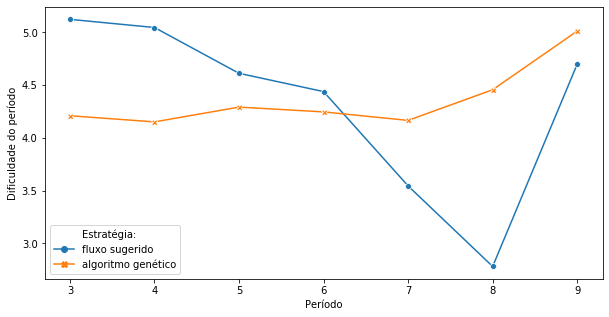

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

scores = np.array( [ sorted([ (a.gerar_notas(y), y) for y in x ], key=lambda x: x[0]) for x in curso ])
scores = np.array([ np.array([ x[0] for x in y ]) for y in scores ])
scores = [ np.mean(x) for x in scores]

from collections import defaultdict
tmp = defaultdict(list)
for item in a.criar_fluxo(periodos=10, lim=5):
    tmp[item[1]].append(item[0])
    
tmp = [x[1] for x in sorted(tmp.items(), key=lambda x: x[0])]

fluxo_scores = np.array( [ sorted([ (a.gerar_notas(y), y) for y in x ], key=lambda x: x[0]) for x in tmp ])
fluxo_scores = np.array([ np.array([ x[0] for x in y ]) for y in fluxo_scores ])
fluxo_scores = [ np.mean(x) for x in fluxo_scores]
valores_fluxo = fluxo_scores[(len(fluxo_scores) - len(scores)):len(fluxo_scores)]
valores_algo = scores
media_global = np.mean(fluxo_scores)

valores_fluxo = [ [i, 10 - v, 'fluxo sugerido'] for i,v in enumerate(valores_fluxo) ]
valores_algo = [ [i, 10 - v, 'algoritmo genético'] for i,v in enumerate(valores_algo) ]
dataplot = valores_fluxo + valores_algo
dataplot = pd.DataFrame(dataplot)\
.rename(columns={
    2: 'Estratégia:'
})
g = sns.lineplot(x=0, y=1, hue='Estratégia:', style='Estratégia:', markers=True, dashes=False, data=dataplot)
g.axes.set(xlabel='Período')
g.axes.set(xticklabels=[3,3,4,5,6,7,8,9])
g.axes.set(ylabel='Dificuldade do período')
pass